# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Значение метрики качества *F1* не меньше 0.75. 


#### Ход исследования

- загрузка и ознакомление с данными
- проведем анализ некоторых особенностей
- очистим и подготовим данные к обучению
- создадим и обучим несколько моделей
- проведем анализ и сравнение результатов


#### Итоговый вывод:

Для обучения модели дан размеченный датасет комментариев(твитов).
На этапе ознакомления данных мы удалили столбец не содержащий ценной информации.
В датасете токсичных комментариев около 10%. Но для выбранной метрики это не так важно.
Обнаружили что в среднем токсичный комментарий более короткий, содержит большую долю уникальных символов, количество символов в верхнем регистре чуть выше чем в не токсичном.
Провели очистку текста от спецсимволов, привели слова к лемматизированной форме, удалили стопслова.
Векторизацию текста делали с учетом n-gramm  от 1 до 3
Выбор моделей осуществляли в том числе и по скорости работы.
В результате полученная модель справляется с задачей с заданной точностью.
Для более точного предсказания негативного комментария, в зависимости от цели бизнеса, необходимо будет скорректировать порог.

**Описание данных**

Столбец *text* содержит текст комментария,\
*toxic* — целевой признак

## Подготовка

Загрузим необходимые библиотеки

In [ ]:
import os
import re
import string

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import numpy as np

import pandas as pd
pd.set_option('max_colwidth', 0)
pd.set_option('display.width', 1080)

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

from sklearn import metrics, model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

from scipy import stats

import spacy

from wordcloud import WordCloud

In [4]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
    print("Датасета успешно загружен c GoogleDisc")
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
    print("Датасета успешно загружен c Яндекс.Практикум")
else:
    print("Проверьте правильность пути к датасету")

Датасета успешно загружен c GoogleDisc


In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [6]:
df.tail(5)

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0
159291,159450,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0


Сразу можно заметить наличие в тексте спец символов и  информации которая может нам помешать обучению модели:
- даты,
- хэштэги,
- знаки переноса строки, и т.д.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [8]:
df.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


Выборка не сбалансирована по целевому признаку негативных комментариев всего около 10 %. Но так как для оценки качества модели используется метрика F1, дисбаланс классов на качество не повлияет.

Столбец Unnamed: 0 не совпадает с нумерацией по индексу. Проверим

In [9]:
df.iloc[df[df['Unnamed: 0'] > df.index].index[0] - 1] # место перед тем, где индекс начинает отличаться от Unnamed: 0

Unnamed: 0    6079                                                                                                                                                                                                                                                                                                                  
text          Hrafn \n\nPM, Where did Hrafn go? There was a proper method to retire from WP, but he did not use it. Instead, it sounded like he was depressed and wanted an Admin to do it for him. It would be nice to have him back, and, as his friendly nemesis, I have asked him to come back. Perhaps your should do the same.
toxic         0                                                                                                                                                                                                                                                                                                                     
Name: 6079, dtype: object

In [10]:
df.iloc[df[df['Unnamed: 0'] > df.index].index[0]] # следующий после отличающегося

Unnamed: 0    6084                                                                                                              
text          "::I'll alos be looking in to see how this is going, as GRC is a big deal around these parts. Seek his grace \n\n"
toxic         0                                                                                                                 
Name: 6080, dtype: object

Столбец `Unnamed: 0` показывает нумерацию твитов отличную от индекса. Похоже что некоторые сообщения были склеены из сообщений одного автора когда он отвечает сам на свой твит либо дополняет его. Нумерация сообщений нам не нужна столбец удаляем

In [11]:
df = df.drop('Unnamed: 0', axis=1)

In [12]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [13]:
df.duplicated().sum()

0

Пропуски и дубликаты отсутствуют

Проверим как распределены длинны текстов

In [14]:
df['text_len'] = df['text'].apply(lambda x: len(x))

In [104]:
df.head()

,text,toxic,text_len,text_len_unic_simbol,upper_simb,words
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren vandalisms just closure on some gas after i voted at new york dolls fac and please don remove the template from the talk page since i retired,0,264,0.185606,0.064394,explanation edit make username hardcore metallica fan revert vandalism closure gas vote new york dolls fac please remove template talk page since retire
1,d he matches this background colour i seemingly stuck with thanks talk january utc,0,112,0.348214,0.071429,match background colour seemingly stuck thank talk january utc
2,hey man i really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0,233,0.124464,0.017167,hey man really try edit war guy constantly remove relevant information talk edit instead talk page seem care format actual info
3,more i can make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it listed in the relevant form eg wikipediagood hashtag,0,622,0.061093,0.017685,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidying exact format ie date format etc later noone else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipediagood hashtag
4,you sir are my hero any chance you remember what page that on,0,67,0.358209,0.029851,sir hero chance remember page


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      159292 non-null  object
 1   toxic     159292 non-null  int64 
 2   text_len  159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [105]:
df.describe()

,toxic,text_len,text_len_unic_simbol,upper_simb
count,159292.000000,159292.000000,159292.000000,159292.000000
mean,0.101612,393.691303,0.210454,0.051619
std,0.302139,590.111825,0.159631,0.092817
min,0.000000,5.000000,0.000600,0.000000
25%,0.000000,95.000000,0.089552,0.020706
50%,0.000000,205.000000,0.162896,0.031746
75%,0.000000,435.000000,0.288660,0.048825
max,1.000000,5000.000000,1.000000,0.998189


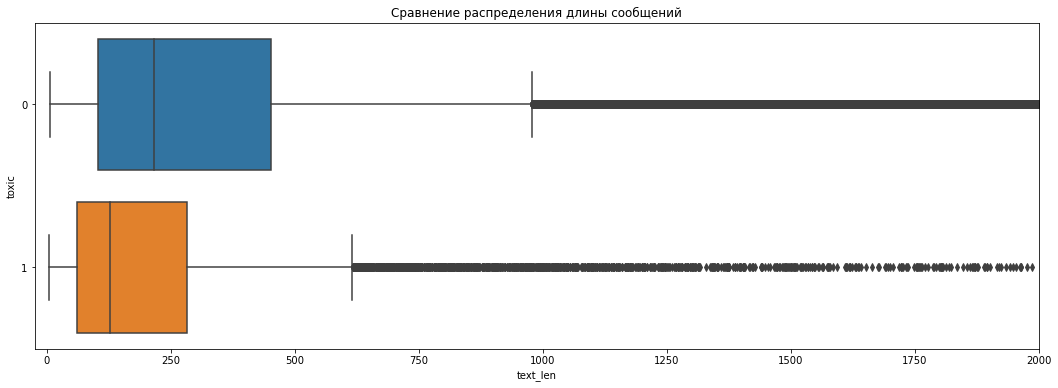

In [106]:
plt.figure(figsize=(18,6))
plt.title('Сравнение распределения длины сообщений')
sns.boxplot(x = "text_len", y = "toxic", data=df, orient='h')
plt.xlim(-25, 2000);

Токсичные комментарии более короткие

In [60]:
df['text_len_unic_simbol'] = df['text'].apply(lambda x: len(set(x))) / df['text_len']

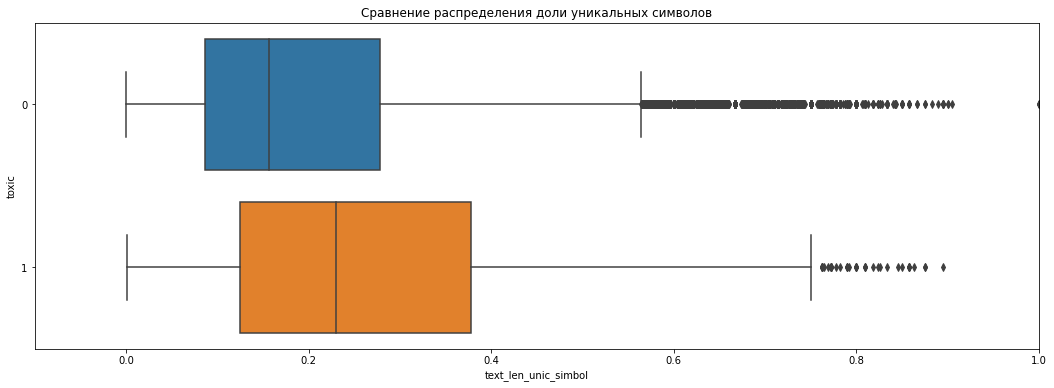

In [107]:
plt.figure(figsize=(18,6))
plt.title('Сравнение распределения доли уникальных символов')
sns.boxplot(x = "text_len_unic_simbol", y = "toxic", data=df, orient='h')
plt.xlim(-0.1, 1);

Доля уникальных символов в тексте токсичного комментария выше и составляет 0,23, для не токсичного 0,15

In [65]:
df['upper_simb'] = df['text'].apply(lambda x: len([x for x in x if x.isupper()])) / df['text_len']

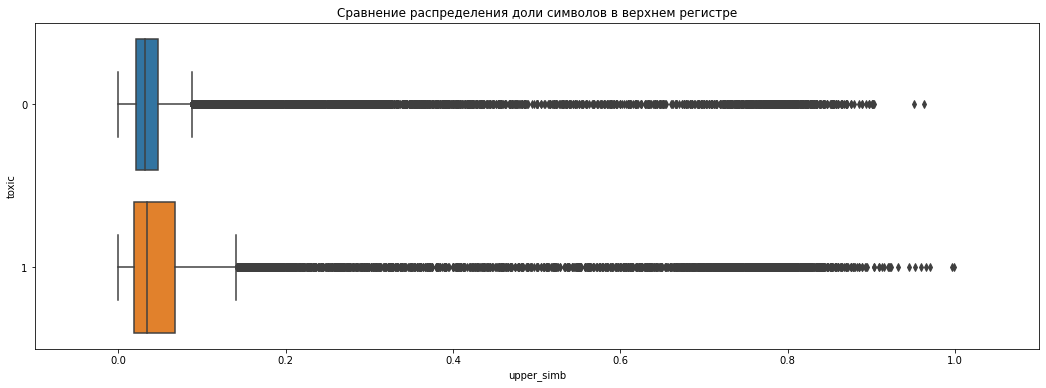

In [109]:
plt.figure(figsize=(18,6))
plt.title('Сравнение распределения доли символов в верхнем регистре')
sns.boxplot(x = "upper_simb", y = "toxic", data=df, orient='h')
plt.xlim(-0.1, 1.1);

Доля символов в верхнем регистре к общему количеству символов для токсичных комметариев в среднем чуть больше и встречается чаще

In [70]:
df[df['text'].str.contains('http')]['text'].count()

4759

In [71]:
df[df['text'].str.contains('@')]['text'].count()

1158

In [72]:
df[df['text'].str.contains('_')]['text'].count()

4363

In [73]:
df[df['text'].str.contains('UTC')]['text'].count()

6278

Создадим функцию для очистки текста

In [74]:
def clean_text(text:str):
    '''
    Функция очищает текст от лишних символов:
    - удаляет все что в квадратных скобках;
    - заменяет ссылки начинающиеся с http и www на site;
    - упоминания пользователей @ на user;
    - хэштэги # на hashtag;
    - символ "_" на пробел;
    - все что в <> на пробел;
    - пунктуацию удаляет;
    - переносы строк \n на пробел;
    - цифры прочие на пробел;
    - удаляет лишние пробелы
    
    Arguments:
    text -- str
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', ' ', text) # все что в квадратных скобках
    text = re.sub('https?://\S+|www\.\S+', 'site', text) # ссылки меняем на site
    text = re.sub(r'@\w+','user', text) # упоминания на user
    text = re.sub(r'#\w+',' hashtag', text) # хэштэги на hashtag
    text = re.sub(r'_\w+',' ', text) # underscore на пробел
    text = re.sub(r"'\w+",' ', text) # ' на пробел и то что после типа I'm, cann't
    text = re.sub('<.*?>+', ' ', text) # < >
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # пунктуация
    text = re.sub('\n', ' ', text) #переносы на пробел
    text = re.sub('\w*\d\w*', ' ', text) #цифры и пр
    text = re.sub(r'[^a-z]', ' ', text)# вдруг что то осталось
    text = re.sub(r"^\s+", "", text) # пробел в начале
    text = re.sub(r"\s+$", "", text) # пробел в конце
    text = re.sub(" +", " ", text) # пробелы
    return text

Очистим текст

In [75]:
df['text'] = df['text'].apply(clean_text)
df['text'].head(8)

0    explanation why the edits made under my username hardcore metallica fan were reverted they weren vandalisms just closure on some gas after i voted at new york dolls fac and please don remove the template from the talk page since i retired                                                                                                                                                                                                                                                                                                                                               
1    d he matches this background colour i seemingly stuck with thanks talk january utc                                                                                                                                                                                                                                                                                                                                              

Разобьем текст по словам для дальнейшей обработки

In [76]:
df['words'] = df['text'].apply(lambda x: x.split(' '))
df['words']

0         [explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, reverted, they, weren, vandalisms, just, closure, on, some, gas, after, i, voted, at, new, york, dolls, fac, and, please, don, remove, the, template, from, the, talk, page, since, i, retired]                                                                                                                                                                                                                                                                                                                                                   
1         [d, he, matches, this, background, colour, i, seemingly, stuck, with, thanks, talk, january, utc]                                                                                                                                                                                                                                                                      

Удалим стопслова, т.е. слова не несущие значительной смысловой нагрузки

In [77]:
stop_words = stopwords.words('english')
df['words'] = df['words'].apply(lambda words: [word for word in words if not word in stop_words])
df.head()

,text,toxic,text_len,text_len_unic_simbol,upper_simb,words
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren vandalisms just closure on some gas after i voted at new york dolls fac and please don remove the template from the talk page since i retired,0,264,0.185606,0.064394,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]"
1,d he matches this background colour i seemingly stuck with thanks talk january utc,0,112,0.348214,0.071429,"[matches, background, colour, seemingly, stuck, thanks, talk, january, utc]"
2,hey man i really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0,233,0.124464,0.017167,"[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]"
3,more i can make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it listed in the relevant form eg wikipediagood hashtag,0,622,0.061093,0.017685,"[make, real, suggestions, improvement, wondered, section, statistics, later, subsection, types, accidents, think, references, may, need, tidying, exact, format, ie, date, format, etc, later, noone, else, first, preferences, formatting, style, references, want, please, let, know, appears, backlog, articles, review, guess, may, delay, reviewer, turns, listed, relevant, form, eg, wikipediagood, hashtag]"
4,you sir are my hero any chance you remember what page that on,0,67,0.358209,0.029851,"[sir, hero, chance, remember, page]"


Приведем слова к упрощенной словарной форме

In [84]:
disabled_pipes = [ "parser",  "ner"]
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)

In [85]:
%%time
df['words'] = df['words'].apply(lambda words: [word.lemma_ for word in nlp(' '.join(words))])

Wall time: 16min 36s


In [29]:
# lemmatizer = nltk.stem.WordNetLemmatizer()
# df['words'] = df['words'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])
# df.head()

Склеим слова в единую строку

In [86]:
df['words'] = df['words'].apply(lambda x: ' '.join(x))
df.head()

,text,toxic,text_len,text_len_unic_simbol,upper_simb,words
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren vandalisms just closure on some gas after i voted at new york dolls fac and please don remove the template from the talk page since i retired,0,264,0.185606,0.064394,explanation edit make username hardcore metallica fan revert vandalism closure gas vote new york dolls fac please remove template talk page since retire
1,d he matches this background colour i seemingly stuck with thanks talk january utc,0,112,0.348214,0.071429,match background colour seemingly stuck thank talk january utc
2,hey man i really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0,233,0.124464,0.017167,hey man really try edit war guy constantly remove relevant information talk edit instead talk page seem care format actual info
3,more i can make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it listed in the relevant form eg wikipediagood hashtag,0,622,0.061093,0.017685,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidying exact format ie date format etc later noone else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipediagood hashtag
4,you sir are my hero any chance you remember what page that on,0,67,0.358209,0.029851,sir hero chance remember page


Посмотрим на самые популярные слова для обоих вариантов целевого признака

<function matplotlib.pyplot.show(close=None, block=None)>

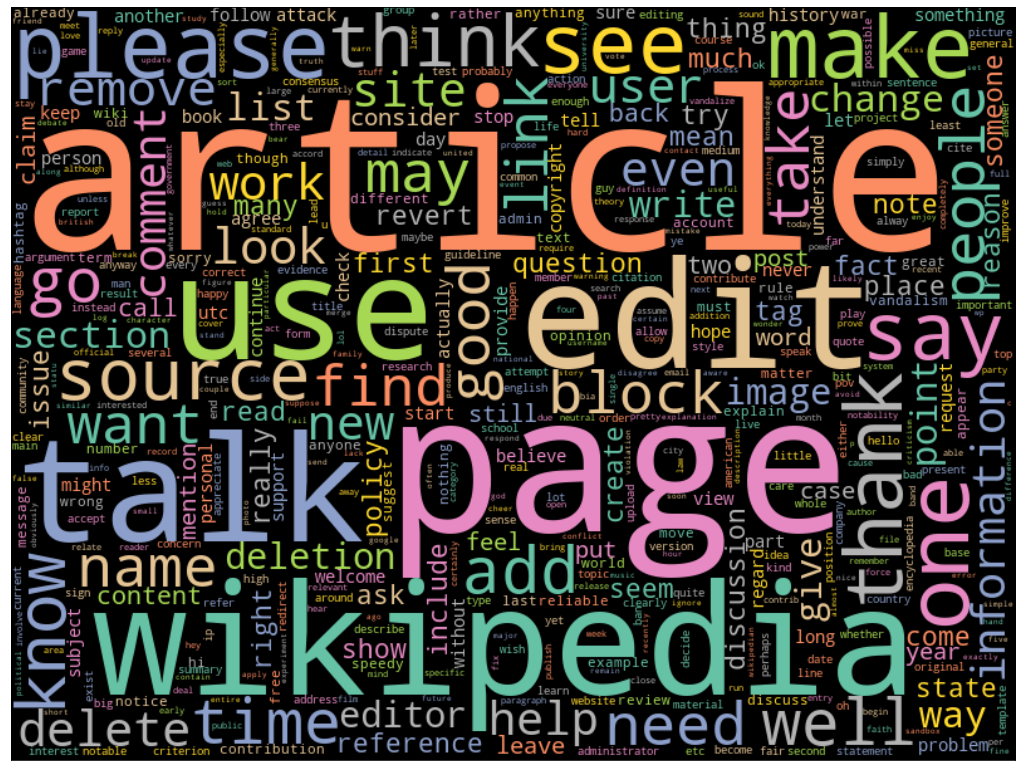

In [87]:
plt.figure(figsize=(18,18))
text = ' '.join(df.query('toxic == 0')['words'].values)
WC = WordCloud(width=800, 
               height=600, 
               max_words=500, 
               min_font_size=5,
               colormap='Set2', 
               collocations=False)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

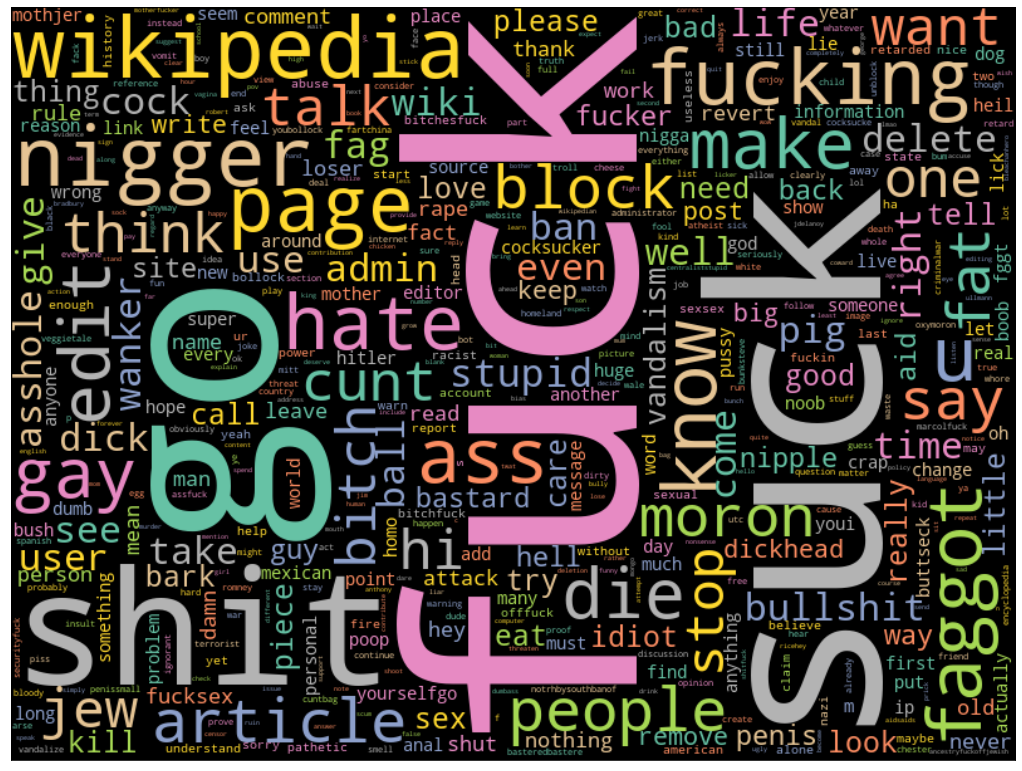

In [88]:
plt.figure(figsize=(18,18))
text = ' '.join(df.query('toxic == 1')['words'].values)
WC = WordCloud(width=800, 
               height=600, 
               max_words=500, 
               min_font_size=5,
               colormap='Set2',
               collocations=False)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show

Вцелом ожидаемо, кроме слова wikipedia - встречается там и там

Разобьем датасет на тренировочную и тестовую выборки

In [89]:
train, test = train_test_split(
    df, 
    test_size=0.1, 
    random_state=47,
    stratify=df['toxic'],
    shuffle=True)

X_train, X_test, y_train, y_test = train['words'], test['words'], train['toxic'], test['toxic']

print('Обучающая выборка:')
print('Доля от общего размера:', round(y_train.shape[0]/df.shape[0], 3))
print('Cтрок, столбцов:', X_train.shape)
print('Доля целевого признака:', round(y_train.mean(), 3))
print('- '*10)


print('Тестовая выборка:')
print('Доля от общего размера:', round(y_test.shape[0]/df.shape[0], 3))
print('Cтрок, столбцов:', X_test.shape)
print('Доля целевого признака:', round(y_test.mean(), 3))
print('-'*30)

Обучающая выборка:
Доля от общего размера: 0.9
Cтрок, столбцов: (143362,)
Доля целевого признака: 0.102
- - - - - - - - - - 
Тестовая выборка:
Доля от общего размера: 0.1
Cтрок, столбцов: (15930,)
Доля целевого признака: 0.102
------------------------------


**Вывод**\
В данном разделе мы ознакомились и провели предобработку данных данных.
В исходном датасете 159292 объекта, с тремя признаками. Повторы и дубликаты не обнаружены
Целевой признак `toxic` определен 0 и 1.
Твитов с целевым признаков равным 1 всего около 10%
Столбец `Unnamed: 0` практически дублирует индекс, за одним исключением, похоже что данный столбец использовался для нумерации без учетов дополнений к постам.
Определили что токсичные комментарии обычно короче(медиана = 128 против 218 у не токсичных)
Доля уникальных символов в тексте токсичного комментария выше и составляет 0,23, для не токскичного 0,15.
Доля символов в верхнем регистре к общему количеству символов примерно одинакова, но для токсичных комметариев частота распределена более широком диапазоне

Далее очистили текст от спец символов, пунктуации, удалили названия сайтов, хэштэги и прочую лишнюю информацию
Очистили от стопслов не несущих ценной информации о содержании комментария
Привели слова к лематизированной форме

Данные для обучения моделей подготовлены

## Обучение

Возмем несколько моделей и попробуем выбрать луччшую из них

In [90]:
pipe = Pipeline(
    [
        ("vector", TfidfVectorizer()),
        ("regressor", LinearSVC())
    ]
)

param_grid = [
    {
        'regressor': [LogisticRegression(random_state=47)],
        'regressor__C': np.linspace(1, 31, 16),
        'regressor__solver': ['saga'],
        'regressor__max_iter': [600]
    },
    {
        'regressor': [LinearSVC(random_state=47)],
        'regressor__C': np.linspace(1, 31, 16),
        'regressor__max_iter': [7000]
    }
]

grid = RandomizedSearchCV(pipe, param_grid, n_iter=4 ,cv=3, scoring = 'f1', verbose=3)

In [91]:
%%time
grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END regressor=LinearSVC(random_state=47), regressor__C=19.0, regressor__max_iter=7000;, score=0.740 total time=  15.3s
[CV 2/3] END regressor=LinearSVC(random_state=47), regressor__C=19.0, regressor__max_iter=7000;, score=0.742 total time=  15.2s
[CV 3/3] END regressor=LinearSVC(random_state=47), regressor__C=19.0, regressor__max_iter=7000;, score=0.738 total time=  16.8s
[CV 1/3] END regressor=LogisticRegression(random_state=47), regressor__C=27.0, regressor__max_iter=600, regressor__solver=saga;, score=0.772 total time=  21.0s
[CV 2/3] END regressor=LogisticRegression(random_state=47), regressor__C=27.0, regressor__max_iter=600, regressor__solver=saga;, score=0.772 total time=  23.3s
[CV 3/3] END regressor=LogisticRegression(random_state=47), regressor__C=27.0, regressor__max_iter=600, regressor__solver=saga;, score=0.772 total time=  22.0s
[CV 1/3] END regressor=LinearSVC(random_state=47), regressor__C=7.0, regress

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vector', TfidfVectorizer()),
                                             ('regressor', LinearSVC())]),
                   n_iter=4,
                   param_distributions=[{'regressor': [LogisticRegression(C=27.0,
                                                                          max_iter=600,
                                                                          random_state=47,
                                                                          solver='saga')],
                                         'regressor__C': array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.,
       27., 29., 31.]),
                                         'regressor__max_iter': [600],
                                         'regressor__solver': ['saga']},
                                        {'regressor': [LinearSVC(random_state=47)],
                                         'regressor__C': array

In [92]:
result = pd.DataFrame(grid.cv_results_)
result.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_iter,param_regressor__C,param_regressor,param_regressor__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,20.083557,0.582053,2.119501,0.419751,600,27.0,"LogisticRegression(C=27.0, max_iter=600, random_state=47, solver='saga')",saga,"{'regressor__solver': 'saga', 'regressor__max_iter': 600, 'regressor__C': 27.0, 'regressor': LogisticRegression(C=27.0, max_iter=600, random_state=47, solver='saga')}",0.771652,0.772484,0.771582,0.771906,0.000410,1
2,8.627874,0.356574,2.095564,0.331072,7000,7.0,LinearSVC(random_state=47),NaN,"{'regressor__max_iter': 7000, 'regressor__C': 7.0, 'regressor': LinearSVC(random_state=47)}",0.760039,0.758304,0.756157,0.758167,0.001588,2
3,12.110855,0.519114,1.854590,0.059172,7000,13.0,LinearSVC(random_state=47),NaN,"{'regressor__max_iter': 7000, 'regressor__C': 13.0, 'regressor': LinearSVC(random_state=47)}",0.747102,0.746371,0.744448,0.745974,0.001119,3
0,14.027121,0.794077,1.838047,0.039466,7000,19.0,LinearSVC(random_state=47),NaN,"{'regressor__max_iter': 7000, 'regressor__C': 19.0, 'regressor': LinearSVC(random_state=47)}",0.740433,0.741571,0.738287,0.740097,0.001362,4


Модель пооказывает лучший результат метрики, а также по скорости обучения.

Проверим результаты на тестовой выборке

In [93]:
# X_test_vec = vector.transform(X_test)
pred = grid.best_estimator_.predict(X_test)
best_f1 = f1_score(y_test, pred)
if best_f1 > 0.75:
    print(f'Условие задачи выполнены, F1 на тестовой выборке составил: {best_f1:0.4f}')
else:
    print(f'Необходимо еще оптимизировать параметры, F1 на тестовой выборке всего лишь: {best_f1:0.4f}')

Условие задачи выполнены, F1 на тестовой выборке составил: 0.7721


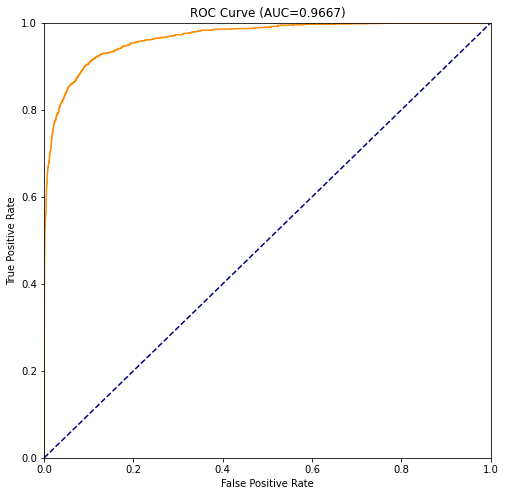

In [100]:
predicted_valid = grid.best_estimator_.decision_function(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_valid)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC={metrics.auc(fpr, tpr):.4f})')
plt.show()

ROC-AUC показывает хороший результат

Посмотрим матрицу распределения ошибок

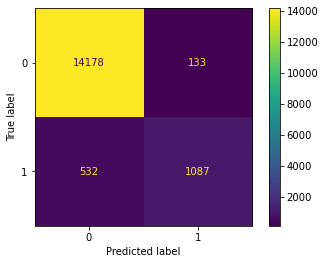

In [101]:
predicted_valid = np.where(predicted_valid > 0.5, 1, 0)
conf_mx = confusion_matrix(y_test, predicted_valid)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mx)
cm_display.plot()

plt.show()

Модель хорошо предсказывет положительные комментарии и довольно часто ошибается в отрицательных.

И сравним результат с dummy моделью

In [102]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
dum_pred = dummy_clf.predict(X_test)
dummy_score = f1_score(y_test, dum_pred)

if best_f1 > dummy_score:
    print(f'Метрика F1 выше у модели на: {best_f1 - dummy_score:0.4f}')
else:
    print(f'Метрика F1 выше у Dummy на: {dummy_score - best_f1:0.4f}, необходимо проверить параметры')

Метрика F1 выше у модели на: 0.6000


## Выводы

В данной работе нам необходимо было создать модель для предсказания токсичных комментариев.

Для обучения модели был дан размеченный датасет комментариев(твитов).
На этапе ознакомления данных иы удалили столбец не содержащий ценной информации.
В обучающем датасете токсичных комментариев около 10%. Но для выбранной метрики это не так важно.
Обнаружили что в среднем токсичный комментарий более короткий, содержит большую долю уникальных символов, количество символов в верхнем регистре чуть выше чем в не токсичном.
Провели очистку текста от спецсимволов, привели слова к лемматизированной форме, удалили стопслова.
Векторизацию текста делали с учетом n-gramm  от 1 до 3
Выбор моделей осуществляли в том числе и по скорости работы.
В результате полученная модель справляется с задачей с заданной точностью.
Но возможно для более точного предсказания негативного комментария необходимо будет скорректировать порог.

Для интернет-магазина «Викишоп» для определения сентимента комметария рекомендуется использовать модель со следющими параметрами

In [103]:
grid.best_estimator_.named_steps["regressor"]

LogisticRegression(C=27.0, max_iter=600, random_state=47, solver='saga')